In [8]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
class PhaseDiff:
    def __init__(self, in_path, out_path):
        self.in_path = in_path
        self.out_path = out_path
        data = np.load(self.in_path, mmap_mode='r')
        print(f"Loaded file of {data.shape} as {data.dtype}")
        csi = data.reshape(-1, 2, 3, 30, 30)
        real = csi[:, 0, ...]
        imag = csi[:, 1, ...]
        self.csi = (np.squeeze(real) + 1.j * np.squeeze(imag))
        self.result = {'AoA': np.zeros(self.csi.shape[0]),
                       'ToF': np.zeros(self.csi.shape[0])}

    def svd(self, mode='aoa'):
        print(f"Calculating {mode}...", end='')
        if mode == 'aoa':
            u, s, v = np.linalg.svd(self.csi.reshape(-1, 3, 30 * 30), full_matrices=False)
            self.result['AoA'] = np.angle(np.squeeze(u[:, 0, 0]).conj() * np.squeeze(u[:, 1, 0]))
        elif mode == 'tof':
            u, s, v = np.linalg.svd(self.csi.transpose(0, 2, 1, 3).reshape(-1, 30, 3 * 30), full_matrices=False)
            self.result['ToF'] = np.average(np.angle(np.squeeze(u[:, :-1, 0])).conj() * np.squeeze(u[:, 1:, 0]), axis=-1)
        else:
            raise Exception('Please specify mode = \'aoa\' or \'tof\'.')
        print("Done!")

    def view(self):
        plt.subplot(1, 2, 1)
        plt.plot(self.result['AoA'][:500])
        plt.title("Estimated AoA")
        plt.subplot(1, 2, 2)
        plt.plot(self.result['ToF'][:500])
        plt.title("Estimated ToF")
        plt.show()

    def save(self):
        if not os.path.exists(self.out_path):
            os.makedirs(self.out_path)
        np.save(f"{self.out_path}pd.npy", np.concatenate(
            (self.result['AoA'][np.newaxis, ...], self.result['ToF'][np.newaxis, ...]), axis=0))
        print("All saved!")


Loaded file of (10990, 6, 30, 30) as float64
Calculating aoa...Done!
Calculating tof...Done!


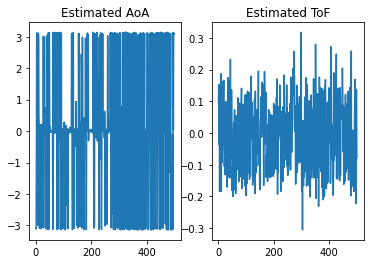

In [6]:
phasediff = PhaseDiff('../dataset/0509/make14-finished/csi.npy', '../dataset/0509/make14-finished/')
phasediff.svd('aoa')
phasediff.svd('tof')
phasediff.view()

In [9]:
phasediff.save()

All saved!


In [10]:
temp4 = np.load(f"../dataset/0509/make14-finished/pd.npy", mmap_mode='r')
print(temp4.shape)

(2, 10990)


In [ ]:
tmp = temp4.reshape(-1, 2, 3, 30, 30)
from scipy import signal
tmp_ = tmp[:, 0, ...] * np.exp(1.j * tmp[:, 1, ...])

tmp_r = signal.savgol_filter(np.real(tmp_), 21, 3, axis=-1) # denoise for real part
tmp_i = signal.savgol_filter(np.imag(tmp_), 21, 3, axis=-1) # denoise for imag part
tmp__ = np.concatenate((tmp_r, tmp_i), axis=1)
print(tmp__.shape)

In [ ]:
np.save('../dataset/0509/make14-filtered/csi.npy', tmp__)